In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import string

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [27]:
francetax = pd.read_parquet('data/france_revenue_tax.parquet')

In [28]:
francetax.head()

,COMMUNE,Libellé commune,ANNEE,TFNB,TFB,TH,POPULATION,TAX_REVENUE
0,1,ABERGEMENT CLEMENCIAT,2022,28443.0,144513.0,18963.0,798.0,191919.0
1,2,ABERGEMENT DE VAREY,2022,788.0,61501.0,14164.0,257.0,76453.0
2,4,AMBERIEU EN BUGEY,2022,23997.0,7483843.0,387180.0,14514.0,7895020.0
3,5,AMBERIEUX EN DOMBES,2022,30661.0,499270.0,54125.0,1776.0,584056.0
4,6,AMBLEON,2022,3001.0,25437.0,6739.0,118.0,35177.0


In [29]:

# Function to standardize municipality names
def standardize_name(name):
    return ''.join(char for char in name if char not in string.punctuation).strip().upper()

# Apply the function to the 'Libellé commune' column
francetax['Libellé commune'] = francetax['Libellé commune'].apply(standardize_name)

# Convert columns to appropriate data types
francetax[['TFNB', 'TFB', 'TH', 'POPULATION']] = francetax[['TFNB', 'TFB', 'TH', 'POPULATION']] .apply(pd.to_numeric, errors='coerce')

# Create a complete range of years for each municipality
years = np.arange(1982, 2023)
all_municipalities = francetax['Libellé commune'].unique()

# Create a complete DataFrame with all municipalities and all years
complete_data = pd.MultiIndex.from_product([all_municipalities, years], names=['Libellé commune', 'ANNEE']).to_frame(index=False)

# Merge with the existing data
data_complete = pd.merge(complete_data, francetax, on=['Libellé commune', 'ANNEE'], how='left')

In [30]:
# Function to fill missing data for each municipality
def fill_missing_data(df):
    for col in ['TFNB', 'TFB', 'TH']:
        df[col] = df[col].fillna(method='ffill')  # Fill using data from the previous year
        if df[col].isna().sum() > 0:
            df[col] = df[col].fillna(df[col].rolling(window=5, min_periods=1).mean())  # Fill remaining using the mean of the previous years
    return df

# Apply the function to each municipality
data_complete = data_complete.groupby('Libellé commune').apply(fill_missing_data).reset_index(drop=True)


In [31]:
def impute_taxes(group):
    for col in ['TFNB', 'TFB', 'TH', 'POPULATION']:
        values = group[col]
        
        for i in range(len(values)):
            if pd.isna(values.iloc[i]):
                # Get the previous 5 years
                previous_values = values.iloc[max(0, i-5):i]
                
                if not previous_values.isna().all():
                    # If there are previous values, use the mean or median
                    if len(previous_values.dropna()) > 0:
                        values.iloc[i] = previous_values.mean()
                    else:
                        values.iloc[i] = previous_values.median()
                else:
                    # If all upcoming years are NaN, impute 0
                    values.iloc[i] = 0
    
    return group

def calculate_tax_revenue(data, current_year):
    data.loc[data['ANNEE'].isin([2019, 2020]), 'TH'] = 0
    # Apply weights based on the year
    data['year_diff'] = current_year - data['ANNEE']
    data['weight'] = 1 / (data['year_diff'] + 1)  # Example weighting: 1 / (years since current year + 1)

    # Calculate weighted tax revenue
    data['Weighted_TFNB'] = data['TFNB'] * data['weight']
    data['Weighted_TFB'] = data['TFB'] * data['weight']
    data['Weighted_TH'] = data['TH'] * data['weight']

    # Sum weighted tax revenues to get the total weighted tax revenue
    data['W_TAX_REVENUE'] = data[['Weighted_TFNB', 'Weighted_TFB', 'Weighted_TH']].sum(axis=1)

    data['TAX_REVENUE'] = data['TFNB'] + data['TFB'] + data['TH']
    return data

# App#ly the imputation function to each municipality group
data = data_complete.groupby('Libellé commune').apply(impute_taxes)
data = calculate_tax_revenue(data, 2022)
data.head()


,Libellé commune,ANNEE,COMMUNE,TFNB,TFB,TH,POPULATION,TAX_REVENUE,year_diff,weight,Weighted_TFNB,Weighted_TFB,Weighted_TH,W_TAX_REVENUE
0,ABERGEMENT CLEMENCIAT,1982,NaN,0.0,0.0,0.0,0.0,0.0,40,0.024390,0.0,0.0,0.0,0.0
1,ABERGEMENT CLEMENCIAT,1983,NaN,0.0,0.0,0.0,0.0,0.0,39,0.025000,0.0,0.0,0.0,0.0
2,ABERGEMENT CLEMENCIAT,1984,NaN,0.0,0.0,0.0,0.0,0.0,38,0.025641,0.0,0.0,0.0,0.0
3,ABERGEMENT CLEMENCIAT,1985,NaN,0.0,0.0,0.0,0.0,0.0,37,0.026316,0.0,0.0,0.0,0.0
4,ABERGEMENT CLEMENCIAT,1986,NaN,0.0,0.0,0.0,0.0,0.0,36,0.027027,0.0,0.0,0.0,0.0


In [32]:

data.isnull().sum()


Libellé commune         0
ANNEE                   0
COMMUNE            740611
TFNB                    0
TFB                     0
TH                      0
POPULATION              0
TAX_REVENUE             0
year_diff               0
weight                  0
Weighted_TFNB           0
Weighted_TFB            0
Weighted_TH             0
W_TAX_REVENUE           0
dtype: int64

In [33]:
data.to_parquet('data/francetax_processed.parquet')

In [39]:
import re
def standardize_name(name):
    return re.sub(r'\W+', '', name).strip().upper()  # Remove non-alphanumeric characters and convert to uppercase

# Create a mapping from standardized names to original names
data['Standardized Name'] = data['Libellé commune'].apply(standardize_name)
name_mapping = data.drop_duplicates('Standardized Name')[['Standardized Name', 'Libellé commune']].set_index('Standardized Name')['Libellé commune'].to_dict()

# Use the standardized names in the main data
data['Libellé commune'] = data['Standardized Name']
data = data.drop(columns=['Standardized Name'])


In [40]:
# Filter municipalities with at least 10 years of data
data = data[data['POPULATION']  > 0]
municipalities_with_10_years = data['Libellé commune'].value_counts()
valid_municipalities = municipalities_with_10_years[municipalities_with_10_years >= 10].index

# Filter the data to include only these municipalities
data_filtered = data[data['Libellé commune'].isin(valid_municipalities)]



In [41]:
# Group by 'Libellé commune' and sum the 'TAX_REVENUE' for each municipality
municipality_revenue = data_filtered.groupby('Libellé commune')['TAX_REVENUE'].sum().reset_index()

# Rename the columns for clarity
municipality_revenue.columns = ['Municipality', 'Total_Tax_Revenue']

# Replace zero or negative Total_Tax_Revenue values with a small positive value
municipality_revenue['Total_Tax_Revenue'] = municipality_revenue['Total_Tax_Revenue'].apply(lambda x: x if x > 0 else 1)
# Apply log transformation
municipality_revenue['Log_Tax_Revenue'] = np.log(municipality_revenue['Total_Tax_Revenue'])

# Sort the municipalities by 'Log_Tax_Revenue' in descending order
sorted_revenue = municipality_revenue.sort_values(by='Log_Tax_Revenue', ascending=False)

# Get the top 5 and bottom 5 municipalities
top_5 = sorted_revenue.head(5)
bottom_5 = sorted_revenue.tail(5)



In [42]:
# Group by 'Libellé commune' and sum the 'TAX_REVENUE' for each municipality
municipality_revenue = data_filtered.groupby('Libellé commune')['W_TAX_REVENUE'].sum().reset_index()

# Rename the columns for clarity
municipality_revenue.columns = ['Municipality', 'Total_Tax_Revenue']

# Replace zero or negative Total_Tax_Revenue values with a small positive value
municipality_revenue['Total_Tax_Revenue'] = municipality_revenue['Total_Tax_Revenue'].apply(lambda x: x if x > 0 else 1)
# Apply log transformation
municipality_revenue['Log_Tax_Revenue'] = np.log(municipality_revenue['Total_Tax_Revenue'])

# Sort the municipalities by 'Log_Tax_Revenue' in descending order
sorted_revenue = municipality_revenue.sort_values(by='Log_Tax_Revenue', ascending=False)

# Get the top 5 and bottom 5 municipalities
top_5w = sorted_revenue.head(5)
bottom_5w = sorted_revenue.tail(5)



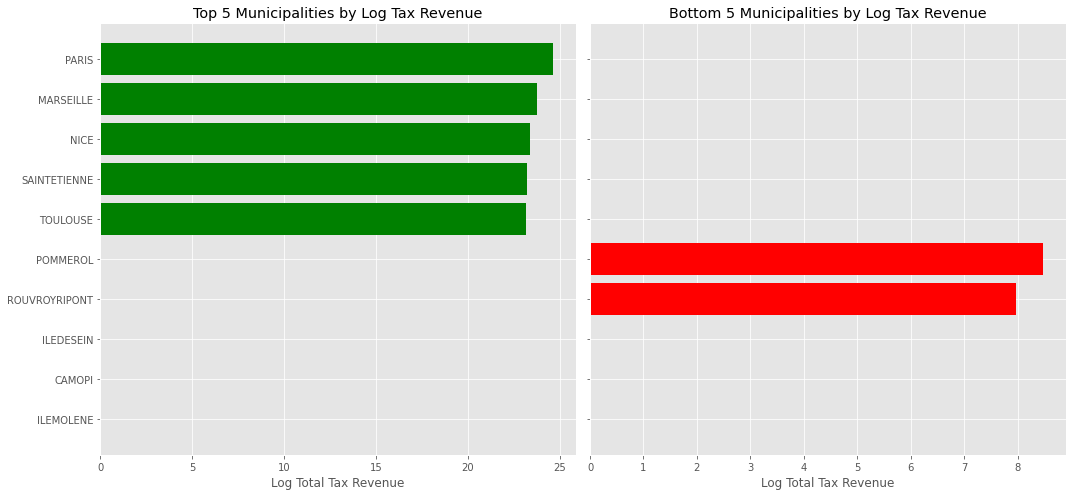

In [43]:


# Create a figure with subplots for top 5 and bottom 5 municipalities
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

# Plot for top 5 municipalities
axs[0].barh(top_5['Municipality'], top_5['Log_Tax_Revenue'], color='green')
axs[0].set_title('Top 5 Municipalities by Log Tax Revenue')
axs[0].set_xlabel('Log Total Tax Revenue')
axs[0].invert_yaxis()

# Plot for bottom 5 municipalities
axs[1].barh(bottom_5['Municipality'], bottom_5['Log_Tax_Revenue'], color='red')
axs[1].set_title('Bottom 5 Municipalities by Log Tax Revenue')
axs[1].set_xlabel('Log Total Tax Revenue')

plt.tight_layout()
plt.show()




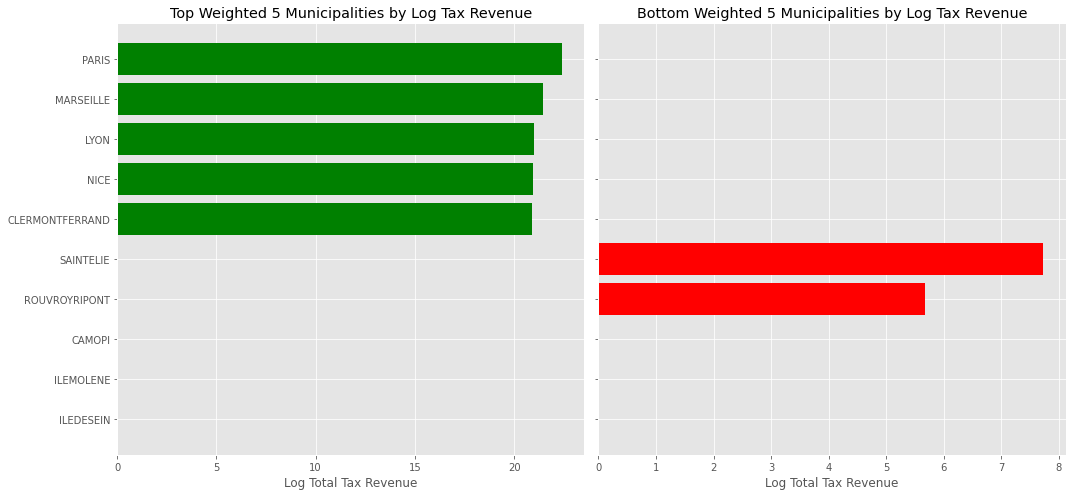

In [44]:


# Create a figure with subplots for top 5 and bottom 5 municipalities
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

# Plot for top 5 municipalities
axs[0].barh(top_5w['Municipality'], top_5w['Log_Tax_Revenue'], color='green')
axs[0].set_title('Top Weighted 5 Municipalities by Log Tax Revenue')
axs[0].set_xlabel('Log Total Tax Revenue')
axs[0].invert_yaxis()

# Plot for bottom 5 municipalities
axs[1].barh(bottom_5w['Municipality'], bottom_5w['Log_Tax_Revenue'], color='red')
axs[1].set_title('Bottom Weighted 5 Municipalities by Log Tax Revenue')
axs[1].set_xlabel('Log Total Tax Revenue')

plt.tight_layout()
plt.show()




In [20]:
data[data['Libellé commune']=='VILLE DE PARIS']

,Libellé commune,ANNEE,COMMUNE,TFNB,TFB,TH,POPULATION,TAX_REVENUE,year_diff,weight,Weighted_TFNB,Weighted_TFB,Weighted_TH,W_TAX_REVENUE
1260083,VILLE DE PARIS,1982,NaN,0.0,0.000000e+00,0.0,0.0,0.000000e+00,40,0.024390,0.000000,0.000000e+00,0.0,0.000000e+00
1260084,VILLE DE PARIS,1983,NaN,0.0,0.000000e+00,0.0,0.0,0.000000e+00,39,0.025000,0.000000,0.000000e+00,0.0,0.000000e+00
1260085,VILLE DE PARIS,1984,NaN,0.0,0.000000e+00,0.0,0.0,0.000000e+00,38,0.025641,0.000000,0.000000e+00,0.0,0.000000e+00
1260086,VILLE DE PARIS,1985,NaN,0.0,0.000000e+00,0.0,0.0,0.000000e+00,37,0.026316,0.000000,0.000000e+00,0.0,0.000000e+00
1260087,VILLE DE PARIS,1986,NaN,0.0,0.000000e+00,0.0,0.0,0.000000e+00,36,0.027027,0.000000,0.000000e+00,0.0,0.000000e+00
1260088,VILLE DE PARIS,1987,NaN,0.0,0.000000e+00,0.0,0.0,0.000000e+00,35,0.027778,0.000000,0.000000e+00,0.0,0.000000e+00
1260089,VILLE DE PARIS,1988,NaN,0.0,0.000000e+00,0.0,0.0,0.000000e+00,34,0.028571,0.000000,0.000000e+00,0.0,0.000000e+00
1260090,VILLE DE PARIS,1989,NaN,0.0,0.000000e+00,0.0,0.0,0.000000e+00,33,0.029412,0.000000,0.000000e+00,0.0,0.000000e+00
1260091,VILLE DE PARIS,1990,NaN,0.0,0.000000e+00,0.0,0.0,0.000000e+00,32,0.030303,0.000000,0.000000e+00,0.0,0.000000e+00
1260092,VILLE DE PARIS,1991,NaN,0.0,0.000000e+00,0.0,0.0,0.000000e+00,31,0.031250,0.000000,0.000000e+00,0.0,0.000000e+00


In [140]:
# Filter data for the top 5 and bottom 5 municipalities
top_5_municipalities = top_5['Municipality'].tolist()
bottom_5_municipalities = bottom_5['Municipality'].tolist()
selected_municipalities = top_5_municipalities + bottom_5_municipalities

# Filter the original dataset to include only these municipalities
trend_data = data[data['Libellé commune'].isin(selected_municipalities)]


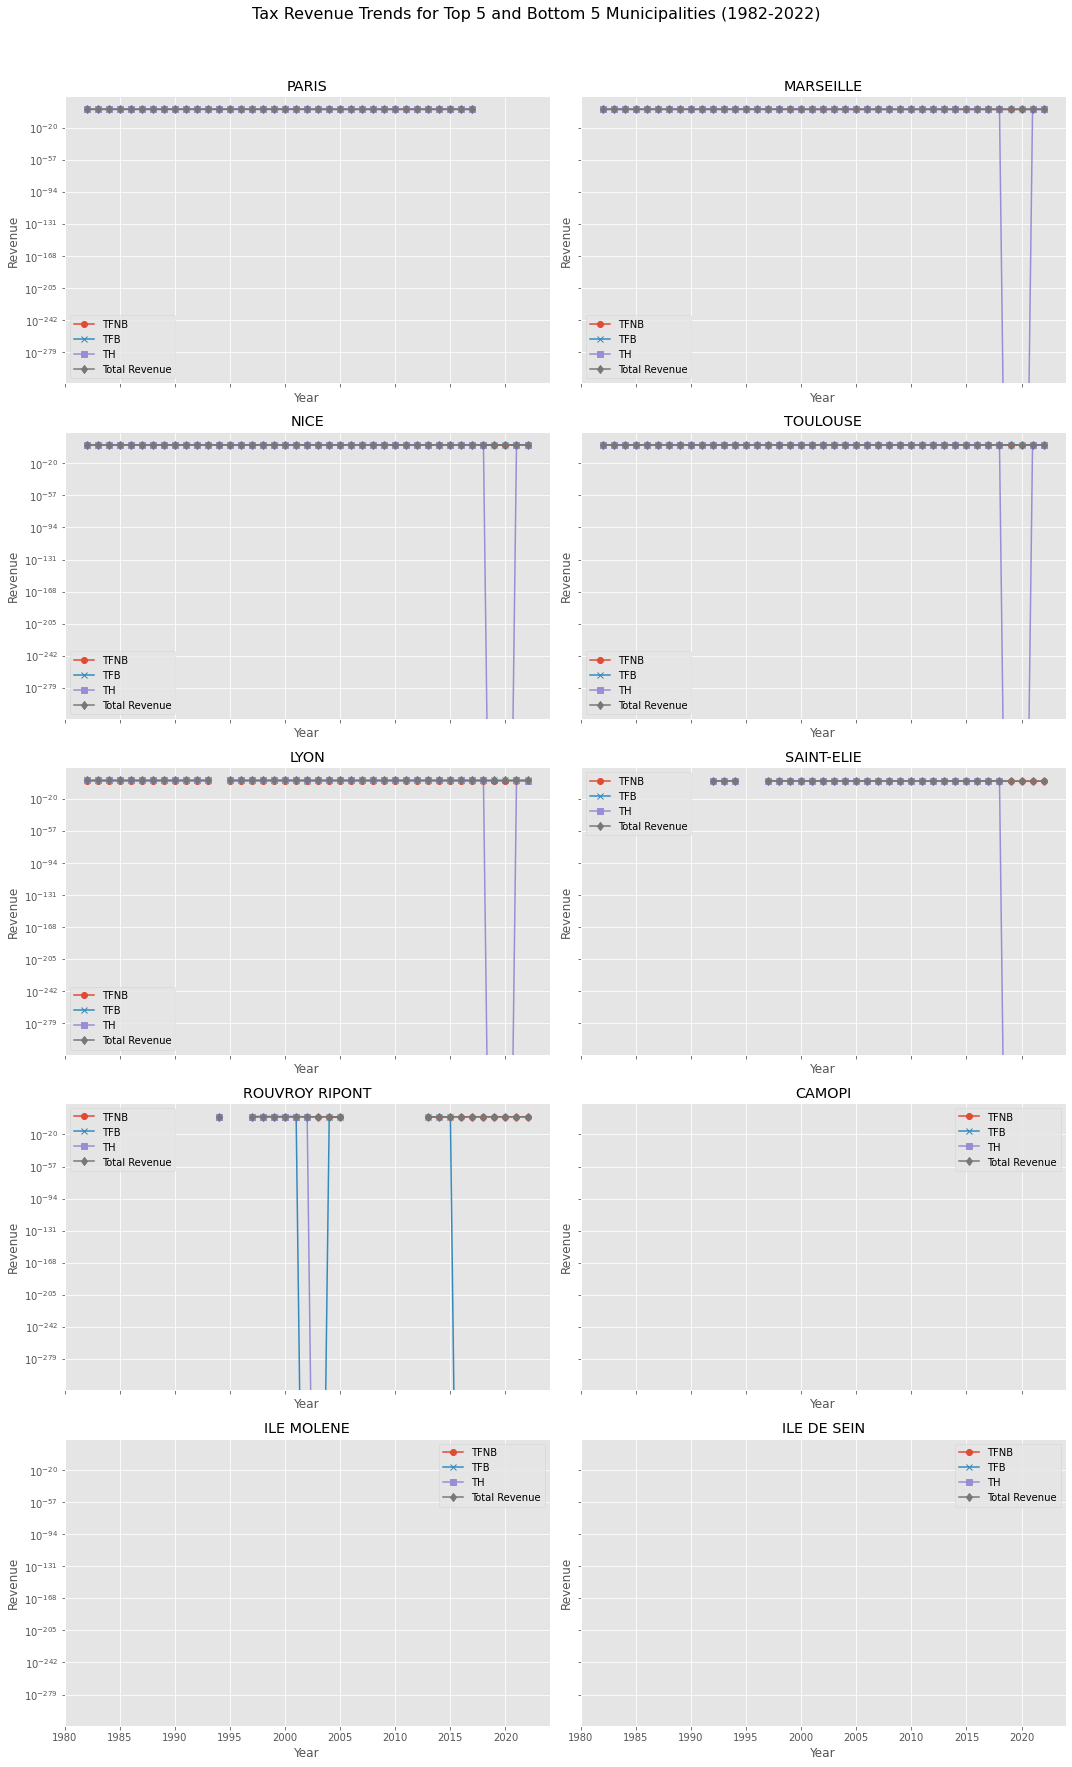

In [141]:
import matplotlib.pyplot as plt

# Ensure the dataset contains the necessary columns and is preprocessed
# data = pd.read_csv('french_fiscality.csv')

# Filter data for the top 5 and bottom 5 municipalities
top_5_municipalities = top_5['Municipality'].tolist()
bottom_5_municipalities = bottom_5['Municipality'].tolist()
selected_municipalities = top_5_municipalities + bottom_5_municipalities

# Filter the original dataset to include only these municipalities
trend_data = data[data['Libellé commune'].isin(selected_municipalities)]

# Calculate the total tax revenue
trend_data['Total_Tax_Revenue'] = trend_data[['TFNB', 'TFB', 'TH']].sum(axis=1)

# Pivot the data to have years as columns for easier plotting
pivot_tfnb = trend_data.pivot_table(values='TFNB', index='ANNEE', columns='Libellé commune')
pivot_tfb = trend_data.pivot_table(values='TFB', index='ANNEE', columns='Libellé commune')
pivot_th = trend_data.pivot_table(values='TH', index='ANNEE', columns='Libellé commune')
pivot_total = trend_data.pivot_table(values='Total_Tax_Revenue', index='ANNEE', columns='Libellé commune')

# Create a figure with subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 25), sharex=True, sharey=True)
fig.suptitle('Tax Revenue Trends for Top 5 and Bottom 5 Municipalities (1982-2022)', fontsize=16)

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot trends for each municipality
for i, municipality in enumerate(selected_municipalities):
    axs[i].plot(pivot_tfnb.index, np.log(pivot_tfnb[municipality]), label='TFNB', marker='o')
    axs[i].plot(pivot_tfb.index, np.log(pivot_tfb[municipality]), label='TFB', marker='x')
    axs[i].plot(pivot_th.index, np.log(pivot_th[municipality]), label='TH', marker='s')
    axs[i].plot(pivot_total.index, np.log(pivot_total[municipality]), label='Total Revenue', marker='d')
    axs[i].set_title(municipality)
    axs[i].set_yscale('log')  # Use log scale for better visualization
    axs[i].grid(True)

# Add legends
for ax in axs:
    ax.legend()

# Set common labels
for ax in axs:
    ax.set_xlabel('Year')
    ax.set_ylabel('Revenue')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.show()


In [122]:
pivot_tfnb.index

Int64Index([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
            1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
            2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
            2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
           dtype='int64', name='ANNEE')